# Electricity Demand Forecasting for Los Angeles, US
**Project 3 for CIVL4100R-Practical Machine Learning for Smart Infrastructure Systems**

## Contents

1. [Introduction](#intro)
2. [Data description](#description)
3. [Exploratory data analysis(EDA)](#EDA)
4. [Feature engineering](#features)
5. [Model train and evalution ](#model)
    - [Long Short-Term Memory Networks(LSTM)](#lstm)
    - [Prophet](#prophet)
    - [Extreme Gradient Boosting(XGBoost)](#xgboost)
6. [Model comparison](#com)

<a id='intro'></a>
## 1. Introduction

Electricity demand forecasting is critical to power generation resource planning, evaluating energy efficiency programs, and tracking greenhouse gas emissions. Temperature-sensitive city-scale electricity consumption analysis is becoming an important topic under the context of climate change, leading to more frequent, more severe, and longer extreme weather events such as heat waves.

This project focuses on short term forecasting, specifically **week ahead daily electricity demand forecasts** for Los Angeles, US., using the **Simulated Historical Forecasts** approach.
Historical daily electricity demand, daily peak-electricity power, weather data and  temporal information(such as holiday, weekend etc.)  from 07/02/2015 to 07/01/2019 is provided. Besides, in our objective to forecast daily electricity consumption for the upcoming week, we assume the  **future week's  daily mean temperature, daily peak temperature, temporal information(such as holiday, weekend etc.)  are known**.  You will develop three AI models - LSTM, Prophet and XGBoost - to accurately predict the daily electricity usage

<a id='description'></a>
## 2. Data description

 There are seven fields in this dataset("la_data.csv"):
 - **Electricity demand, daily sum, (GWh)**: represents the total amount of electricity demand per day of Los Angeles, measured in gigawatt hours (GWh).
 - **Electricity power, daily peak, (GW)**: represents the daily peak electricity demand, i.e., the maximum power demand during a day, measured in gigawatts (GW).
 - **Temperature, daily mean (degC)**: represents the average temperature per day, measured in degrees Celsius (℃).
 - **Temperature, daily peak (degC)**: represents the highest temperature of the day, measured in degrees Celsius (℃).
 - **Holiday**: indicates whether the day is a holiday, with True if it is a holiday and False otherwise.
 - **Weekend**: indicates whether the day is a weekend, with True if it is a weekend and False otherwise.
 - **Non-workDay**:  indicates whether the day is a non-work day, with True if it is a non-work day and False otherwise.

<a id='EDA'></a>
## 3. Exploratory data analysis (4 points)

Conduct an exploratory data analysis to visualize this dataset

In [1]:
import io
import pandas as pd
from google.colab import files


# Upload the dataset file
uploaded = files.upload()

# Get the filename from the uploaded keys
filename = list(uploaded.keys())[0]

# Read the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving la_data.csv to la_data.csv


In [ ]:
from IPython.display import display

# Display the first few rows of the dataset
display(data.head())

# Summary statistics
display(data.describe())

# Check for missing values
display(data.isnull().sum())

,Unnamed: 0,"Electricity demand, daily sum, (GWh)","Electricity power, daily peak, (GW)","Temperature, daily mean (degC)","Temperature, daily peak (degC)",Holiday,Weekend,Non-workDay
0,2015-07-02,93.135,5.012,25.641667,31.7,False,False,False
1,2015-07-03,84.486,4.488,23.500000,30.6,True,False,True
2,2015-07-04,74.337,3.748,21.489583,27.2,False,True,True
3,2015-07-05,70.692,3.547,20.296528,25.6,False,True,True
4,2015-07-06,79.813,4.143,20.288889,25.6,False,False,False


,"Electricity demand, daily sum, (GWh)","Electricity power, daily peak, (GW)","Temperature, daily mean (degC)","Temperature, daily peak (degC)"
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,77.807120,3.964178,18.624418,24.776956
std,12.273711,0.820233,5.174260,6.334122
min,58.778000,2.891000,6.804167,11.100000
25%,69.749000,3.398000,14.816667,20.000000
50%,74.161000,3.653000,18.184028,24.400000
75%,83.049000,4.368000,22.462500,29.400000
max,128.593000,7.095000,35.600000,45.000000


Unnamed: 0                              0
Electricity demand, daily sum, (GWh)    0
Electricity power, daily peak, (GW)     0
Temperature, daily mean (degC)          0
Temperature, daily peak (degC)          0
Holiday                                 0
Weekend                                 0
Non-workDay                             0
dtype: int64

In [3]:

# Convert the first column to datetime in "year-month-day" format and rename it to 'Date'
data['Date'] = pd.to_datetime(data['Unnamed: 0'])

# Drop the original unnamed column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Sort the DataFrame by date
data = data.sort_values(by='Date')

# Reorder the columns so that 'Date' is the first column
data = data[['Date'] + [col for col in data.columns if col != 'Date']]



In [ ]:
# Display the updated DataFrame
display(data.head())

,Date,"Electricity demand, daily sum, (GWh)","Electricity power, daily peak, (GW)","Temperature, daily mean (degC)","Temperature, daily peak (degC)",Holiday,Weekend,Non-workDay
0,2015-07-02,93.135,5.012,25.641667,31.7,False,False,False
1,2015-07-03,84.486,4.488,23.500000,30.6,True,False,True
2,2015-07-04,74.337,3.748,21.489583,27.2,False,True,True
3,2015-07-05,70.692,3.547,20.296528,25.6,False,True,True
4,2015-07-06,79.813,4.143,20.288889,25.6,False,False,False


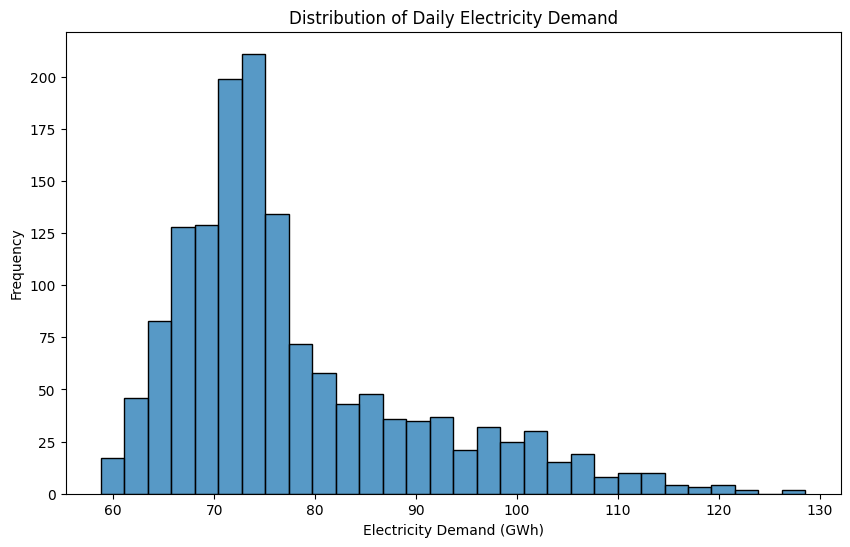

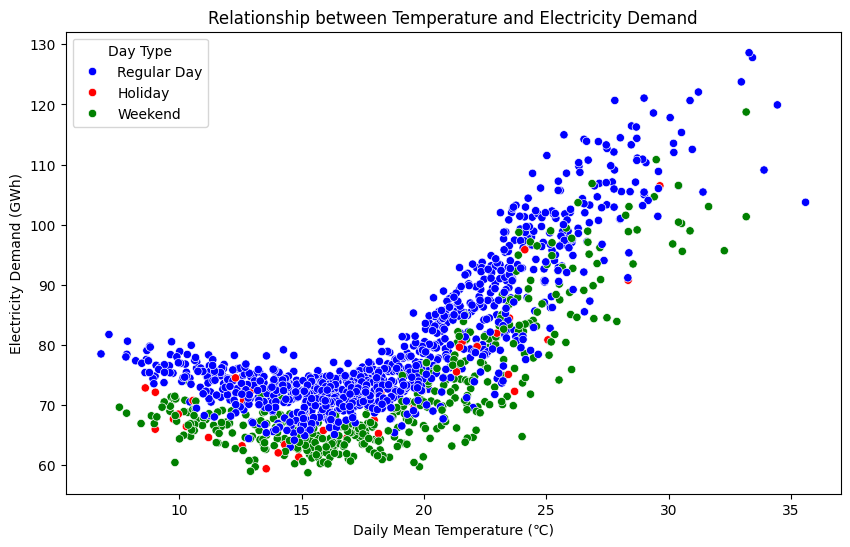

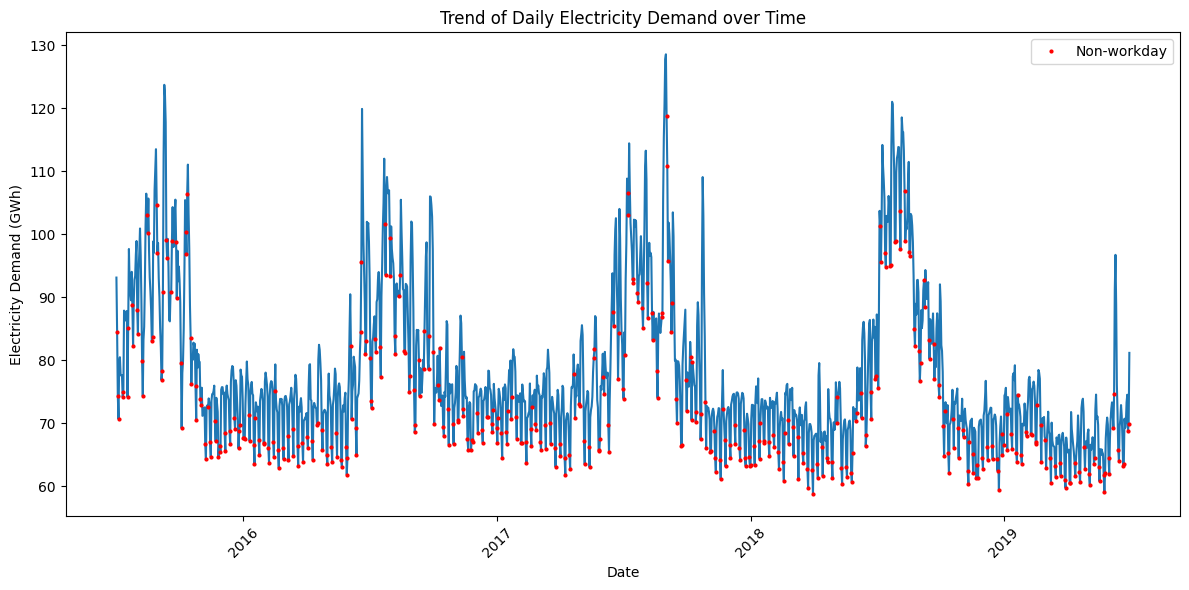

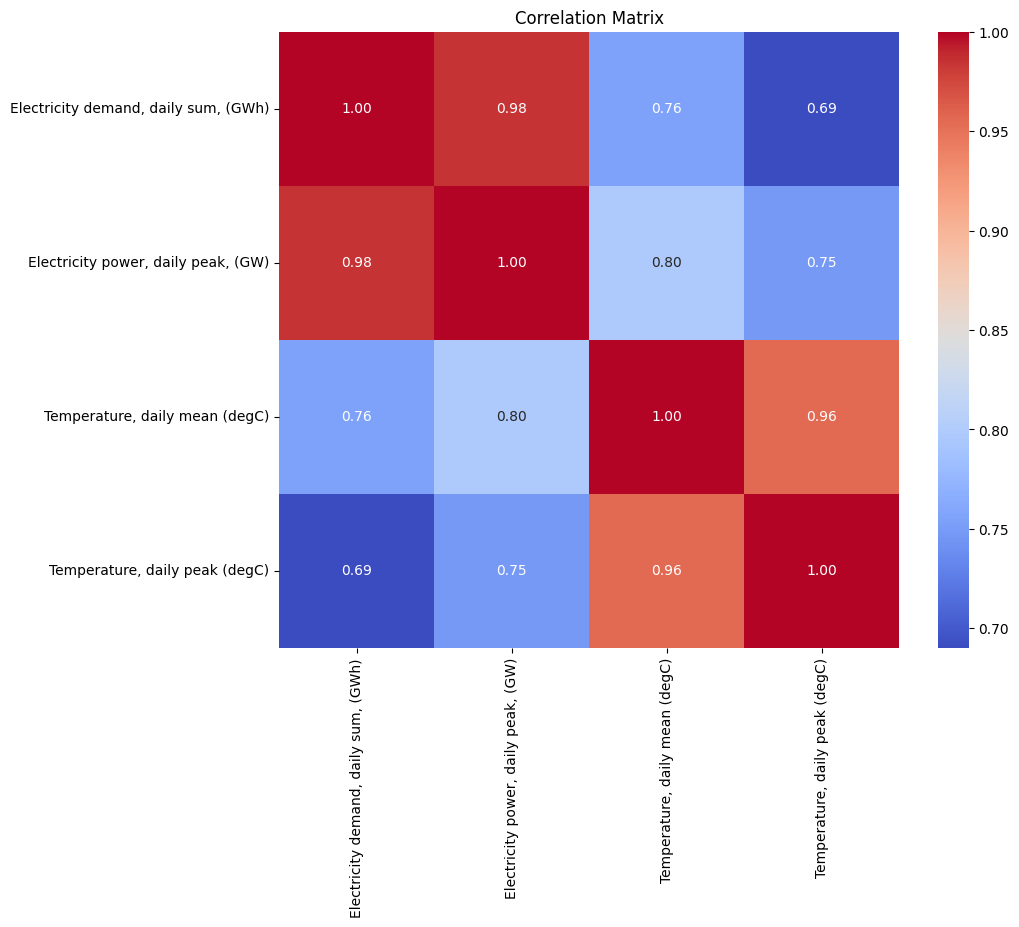

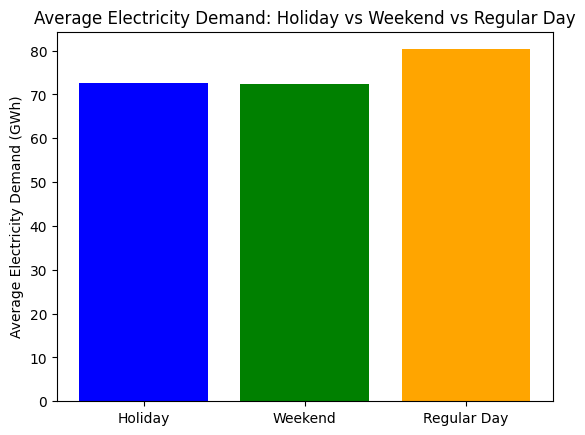

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.initializers import Orthogonal


# Visualize the distribution of electricity demand
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Electricity demand, daily sum, (GWh)', bins=30, kde=False)
plt.title('Distribution of Daily Electricity Demand')
plt.xlabel('Electricity Demand (GWh)')
plt.ylabel('Frequency')
plt.show()



# Define colors for regular days, weekends, and holidays
colors = {'Regular Day': 'blue', 'Weekend': 'green', 'Holiday': 'red'}

# Create a new column for day type
data['Day Type'] = 'Regular Day'
data.loc[data['Weekend'], 'Day Type'] = 'Weekend'
data.loc[data['Holiday'], 'Day Type'] = 'Holiday'

# Scatter plot with colors for each day type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Temperature, daily mean (degC)', y='Electricity demand, daily sum, (GWh)',
                hue='Day Type', palette=colors)

plt.title('Relationship between Temperature and Electricity Demand')
plt.xlabel('Daily Mean Temperature (℃)')
plt.ylabel('Electricity Demand (GWh)')
plt.legend(title='Day Type')
plt.show()



# Plot the trend of electricity demand over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Electricity demand, daily sum, (GWh)')
plt.title('Trend of Daily Electricity Demand over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (GWh)')

# Set the tick locator to display only the beginning of each year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add red dots for non-workdays
non_workdays = data[data['Non-workDay']]
plt.plot(non_workdays['Date'], non_workdays['Electricity demand, daily sum, (GWh)'], 'ro', label='Non-workday', markersize=2)

plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



# Convert 'Unnamed: 0' column to datetime and set it as index

# Select only the numerical columns for correlation calculation
numerical_columns = ['Electricity demand, daily sum, (GWh)', 'Electricity power, daily peak, (GW)',
                     'Temperature, daily mean (degC)', 'Temperature, daily peak (degC)']
numerical_data = data[numerical_columns]

# Visualize the correlation matrix for numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Group the data by 'Holiday', 'Weekend', and 'Non-workDay', and calculate the average electricity demand
demand_by_day_type = data.groupby(['Holiday', 'Weekend', 'Non-workDay'])['Electricity demand, daily sum, (GWh)'].mean().reset_index()

# Filter the data for holidays, weekends, and regular days
holiday_demand = demand_by_day_type[demand_by_day_type['Holiday'] == True]['Electricity demand, daily sum, (GWh)'].values[0]
weekend_demand = demand_by_day_type[demand_by_day_type['Weekend'] == True]['Electricity demand, daily sum, (GWh)'].values[0]
regular_demand = demand_by_day_type[(demand_by_day_type['Holiday'] == False) & (demand_by_day_type['Weekend'] == False) & (demand_by_day_type['Non-workDay'] == False)]['Electricity demand, daily sum, (GWh)'].values[0]

# Create a bar plot
plt.bar(['Holiday', 'Weekend', 'Regular Day'], [holiday_demand, weekend_demand, regular_demand], color=['blue', 'green', 'orange'])
plt.title('Average Electricity Demand: Holiday vs Weekend vs Regular Day')
plt.ylabel('Average Electricity Demand (GWh)')
plt.show()



The following trends are important to note:


*   Usually people consume much more energy on working days and much less on weekends and on holidays  
*   The energy usage between weekends and holidays is overall similar and behave in the same manner
*   There is a U shaped correlation between the demand and the temperature
* Peak demand and average demand behave very very similiraly (same for peak temperature and mean temperature)




<a id='features'></a>
## 4. Feature engineering (4 points)
* Select and create relevant features
* Convert categorical feature with one-hot encoding or label encoding

In [5]:
from sklearn.preprocessing import LabelEncoder
# Define a function to determine the season based on the month
def get_season(month):
    if month in [11, 12, 1, 2, 3]:  # wet season (November-March)
        return 'Wet'
    else:  # dry season (April-October)
        return 'Dry'

# Extract month from the Date column
data['Month'] = data['Date'].dt.month

# Apply the function to create the Season column
data['Season'] = data['Month'].apply(get_season)

# Drop the Month column as it's no longer needed
data.drop(columns=['Month'], inplace=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
data_refined = data
# Apply label encoding to categorical features
data_refined['Non-workDay'] = label_encoder.fit_transform(data_refined['Non-workDay'])
data_refined['Season'] = label_encoder.fit_transform(data['Season'])
data_refined = data_refined.drop(['Holiday', 'Weekend'],axis = 1)
# Display the updated dataset with the new column
display(data_refined.head())

,Date,"Electricity demand, daily sum, (GWh)","Electricity power, daily peak, (GW)","Temperature, daily mean (degC)","Temperature, daily peak (degC)",Non-workDay,Season
0,2015-07-02,93.135,5.012,25.641667,31.7,0,0
1,2015-07-03,84.486,4.488,23.500000,30.6,1,0
2,2015-07-04,74.337,3.748,21.489583,27.2,1,0
3,2015-07-05,70.692,3.547,20.296528,25.6,1,0
4,2015-07-06,79.813,4.143,20.288889,25.6,0,0


A new variable has been added :  **The seasons**

It was inspire by the following information:
https://seasonsyear.com/USA/California/Los-Angeles

*The city lies within zone of subtropical climate. It similar to Mediterranean climate but through whole year temperature never drops below 50 °F (10 °C) thus it considered as tropical. A year is actually divided into two seasons: wet (November-March) and dry (April-October). Weather conditions in certain region of Los Angeles are depending on distance to the ocean. Difference of temperatures may reach ≈27 °F (15°C).*

<a id='model'></a>
## 5. Model train and evalution (15 Points)

<a id='lstm'></a>
### Long Short-Term Memory Networks(LSTM)  (5 points)

Develop a LSTM  model to predict the electricity demand in the next week.<br>
Requirements: please apply the hyper-parameter tuning methods you’ve learned to improve the model accuracy

#### 1) Data Preparation

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = data_refined.drop(columns=['Date', 'Electricity demand, daily sum, (GWh)', 'Electricity power, daily peak, (GW)'])
y = data_refined['Electricity demand, daily sum, (GWh)']

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshape features for LSTM input: [samples, timesteps, features]
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

#### 2) Design model

In [ ]:
# Define LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### 3) Train the model and save the model

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1, validation_data=(X_test, y_test))
model.save('model.keras')

Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6124.8604 - val_loss: 6311.8560
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6204.8628 - val_loss: 6233.2764
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5950.7422 - val_loss: 6100.1040
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5859.9487 - val_loss: 5899.9473
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5801.7246 - val_loss: 5638.1528
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5293.1655 - val_loss: 5331.9038
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5183.7686 - val_loss: 4998.8081
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4771.7290 - val_loss: 4662.0381
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4392.8960 - val_loss: 4332.1040
Epoch 10/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4122.4766 - val_loss: 4014.5315
Epoch 11/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3821.1182 - val_loss: 3716.1

#### 4) Evaluate model

In [ ]:
loss = model.evaluate(X_test, y_test)
rmse_lstm = np.sqrt(loss)
print("RMSE:",rmse_lstm)
# Calculate CVRMSE
cvrmse_lstm= (rmse_lstm / np.mean(y_test)) * 100
print("CVRMSE:", cvrmse_lstm)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.9040
RMSE: 5.258347006576986
CVRMSE: 6.687472705194943


#### 5) Hyperparameter tuning

In [ ]:
from keras.optimizers import Adam

def create_lstm_model(units, learning_rate, activation_function, epochs):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
    val_loss = history.history['val_loss'][-1]  # Get the validation loss of the last epoch
    return model, val_loss

lstm_units = [50, 100, 150]  # Number of LSTM units
learning_rates = [0.001, 0.01, 0.1]  # Learning rates
activation_functions = ['relu', 'rmsprop']  # Activation functions
epochs = [50, 150, 200, 400, 600]  # Number of epochs

best_model = None
best_val_loss = float('inf')

# Hyperparameter tuning loop
for units in lstm_units:
    for learning_rate in learning_rates:
        for activation_function in activation_functions:
            for epoch in epochs:
                model, val_loss = create_lstm_model(units, learning_rate, activation_function, epoch)
                print(f"Units: {units}, Learning Rate: {learning_rate}, Activation Function: {activation_function}, Epochs: {epoch}, Validation Loss: {val_loss}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model

print("Best Validation Loss:", best_val_loss)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: relu, Epochs: 50, Validation Loss: 244.9893035888672


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: relu, Epochs: 150, Validation Loss: 93.41345977783203


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: relu, Epochs: 200, Validation Loss: 59.99724197387695


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: relu, Epochs: 400, Validation Loss: 20.087169647216797


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: relu, Epochs: 600, Validation Loss: 17.946725845336914


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 50, Validation Loss: 246.5881805419922


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 150, Validation Loss: 96.6617431640625


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 200, Validation Loss: 57.91646194458008


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 400, Validation Loss: 20.14243507385254


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 600, Validation Loss: 17.725400924682617


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: relu, Epochs: 50, Validation Loss: 36.48713302612305


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: relu, Epochs: 150, Validation Loss: 16.71971893310547


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: relu, Epochs: 200, Validation Loss: 17.49436378479004


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: relu, Epochs: 400, Validation Loss: 17.482498168945312


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: relu, Epochs: 600, Validation Loss: 16.762147903442383


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 50, Validation Loss: 39.01475524902344


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 150, Validation Loss: 16.930696487426758


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 200, Validation Loss: 17.250757217407227


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 400, Validation Loss: 17.109304428100586


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 600, Validation Loss: 16.83985710144043


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: relu, Epochs: 50, Validation Loss: 17.712539672851562


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: relu, Epochs: 150, Validation Loss: 19.024110794067383


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: relu, Epochs: 200, Validation Loss: 18.599790573120117


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: relu, Epochs: 400, Validation Loss: 17.997709274291992


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: relu, Epochs: 600, Validation Loss: 17.405363082885742


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 50, Validation Loss: 17.654455184936523


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 150, Validation Loss: 16.790311813354492


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 200, Validation Loss: 20.44435691833496


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 400, Validation Loss: 17.829681396484375


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 50, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 600, Validation Loss: 16.64678192138672


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: relu, Epochs: 50, Validation Loss: 153.68666076660156


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: relu, Epochs: 150, Validation Loss: 62.96648406982422


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: relu, Epochs: 200, Validation Loss: 42.043453216552734


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: relu, Epochs: 400, Validation Loss: 19.491701126098633


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: relu, Epochs: 600, Validation Loss: 18.384443283081055


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 50, Validation Loss: 152.6247100830078


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 150, Validation Loss: 61.827571868896484


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 200, Validation Loss: 41.62348937988281


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 400, Validation Loss: 18.752445220947266


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 600, Validation Loss: 18.11655616760254


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: relu, Epochs: 50, Validation Loss: 30.13231658935547


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: relu, Epochs: 150, Validation Loss: 17.252473831176758


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: relu, Epochs: 200, Validation Loss: 17.013046264648438


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: relu, Epochs: 400, Validation Loss: 16.61565399169922


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: relu, Epochs: 600, Validation Loss: 16.50759506225586


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 50, Validation Loss: 30.81509017944336


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 150, Validation Loss: 17.346546173095703


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 200, Validation Loss: 17.176834106445312


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 400, Validation Loss: 16.910356521606445


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 600, Validation Loss: 17.018199920654297


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: relu, Epochs: 50, Validation Loss: 18.404001235961914


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: relu, Epochs: 150, Validation Loss: 21.435291290283203


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: relu, Epochs: 200, Validation Loss: 17.350685119628906


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: relu, Epochs: 400, Validation Loss: 24.538707733154297


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: relu, Epochs: 600, Validation Loss: 20.332935333251953


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 50, Validation Loss: 17.56028938293457


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 150, Validation Loss: 18.346281051635742


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 200, Validation Loss: 16.60575294494629


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 400, Validation Loss: 17.473424911499023


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 100, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 600, Validation Loss: 19.149686813354492


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: relu, Epochs: 50, Validation Loss: 90.80661010742188


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: relu, Epochs: 150, Validation Loss: 52.53227233886719


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: relu, Epochs: 200, Validation Loss: 36.75048065185547


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: relu, Epochs: 400, Validation Loss: 19.257661819458008


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: relu, Epochs: 600, Validation Loss: 18.251548767089844


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 50, Validation Loss: 91.2345199584961


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 150, Validation Loss: 52.47494125366211


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 200, Validation Loss: 36.70008087158203


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 400, Validation Loss: 19.018842697143555


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.001, Activation Function: rmsprop, Epochs: 600, Validation Loss: 18.25564956665039


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: relu, Epochs: 50, Validation Loss: 23.632261276245117


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: relu, Epochs: 150, Validation Loss: 18.055490493774414


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: relu, Epochs: 200, Validation Loss: 17.197864532470703


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: relu, Epochs: 400, Validation Loss: 16.859817504882812


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: relu, Epochs: 600, Validation Loss: 18.05535125732422


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 50, Validation Loss: 26.00905990600586


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 150, Validation Loss: 16.951229095458984


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 200, Validation Loss: 16.88358497619629


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 400, Validation Loss: 17.40998649597168


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.01, Activation Function: rmsprop, Epochs: 600, Validation Loss: 16.76164436340332


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: relu, Epochs: 50, Validation Loss: 17.973417282104492


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: relu, Epochs: 150, Validation Loss: 22.05364418029785


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: relu, Epochs: 200, Validation Loss: 17.535266876220703


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: relu, Epochs: 400, Validation Loss: 17.676921844482422


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: relu, Epochs: 600, Validation Loss: 18.67693328857422


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 50, Validation Loss: 18.505056381225586


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 150, Validation Loss: 19.00649070739746


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 200, Validation Loss: 19.937211990356445


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 400, Validation Loss: 19.821226119995117


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 150, Learning Rate: 0.1, Activation Function: rmsprop, Epochs: 600, Validation Loss: 17.280765533447266
Best Validation Loss: 16.50759506225586


In [ ]:

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

# Compile the model with the specified learning rate
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit the model with the specified number of epochs and batch size
history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Calculate RMSE
rmse_h_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Calculate CVRMSE
cvrmse_h_lstm= (rmse_h_lstm / np.mean(y_test)) * 100
print("CVRMSE:", cvrmse_h_lstm)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5885.9365 - val_loss: 4926.6279
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4197.7993 - val_loss: 2375.3123
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1885.7233 - val_loss: 995.8219
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 786.3624 - val_loss: 446.1389
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 316.0202 - val_loss: 255.4191
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 209.0054 - val_loss: 196.9010
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 160.8422 - val_loss: 180.5004
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 155.7193 - val_loss: 174.5631
Epoch 9/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 137.8922 - val_loss: 172.1238
Epoch 10/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 141.7760 - val_loss: 169.9683
Epoch 11/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 149.4586 - val_loss: 168.0984
Epoch 12/150
37/37 ━━━━━━

#### 6) Visualize the results
Do some visualizations on our predicted output vs the actual demand data.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


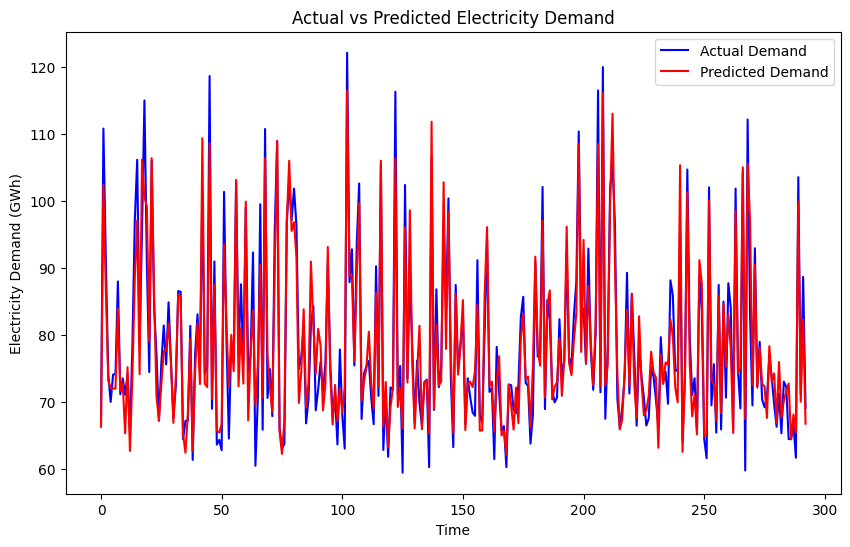

In [ ]:
# Make predictions on the test data
predicted_values = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Demand', color='blue')
plt.plot(predicted_values, label='Predicted Demand', color='red')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Time')
plt.ylabel('Electricity Demand (GWh)')
plt.legend()
plt.show()


<a id='prophet'></a>
### Prophet  (5 points)

Develop a Prophet model to predict the electricity demand in the next week. <br>
Requirements: please apply the hyper-parameter tuning methods you’ve learned to improve the model accuracy

#### 1) Data Preparation

In [ ]:
!pip install prophet



#### 2) Design model

In [6]:
data_refined= data_refined.rename(columns={'Date': 'ds',
                            'Electricity demand, daily sum, (GWh)': 'y',
                            'Electricity power, daily peak, (GW)': 'power_peak',
                            'Temperature, daily mean (degC)': 'temp_mean',
                            'Temperature, daily peak (degC)': 'temp_peak',
                            'Non-workDay': 'non_workday',
                            'Season': 'season'})
data_refined = data_refined.drop(columns=['power_peak'])
# Step 3: Train/Test Split
train_size = int(len(data) * 0.8)
train_data = data_refined[:train_size]
test_data = data_refined[train_size:]



#### 3) Train the model and save the model

In [ ]:
# Step 4: Design the Prophet Model
prophet = Prophet()
prophet.add_regressor('temp_mean')
prophet.add_regressor('temp_peak')
prophet.add_regressor('non_workday')
prophet.add_regressor('season')

# Step 5: Model Training
prophet.fit(train_data)
import pickle

# Save the trained model to a file
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet, f)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznn22vs0/hfkl6e1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznn22vs0/39kf9fg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36898', 'data', 'file=/tmp/tmpznn22vs0/hfkl6e1n.json', 'init=/tmp/tmpznn22vs0/39kf9fg0.json', 'output', 'file=/tmp/tmpznn22vs0/prophet_modele0p6oxhx/prophet_model-20240509052626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:26:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:26:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### 4) Evaluate model and visualize the results

In [ ]:

forecast = prophet.predict(test_data)
rmse_prophet = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
print("Root Mean Squared Error (RMSE):", rmse)
cvrmse_prophet = (rmse / np.mean(test_data['y'])) * 100
print("CVRMSE:", cvrmse_h_lstm)

Root Mean Squared Error (RMSE): 11.57010583912051
CVRMSE: 6.385017083774039


#### 5) Hyperparameter tuning

In [ ]:
# Step 7: Hyperparameter Tuning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_rmse = float('inf')
best_params = {}

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        for holidays_prior_scale in param_grid['holidays_prior_scale']:
            for seasonality_mode in param_grid['seasonality_mode']:
                prophet_tuned = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                                        seasonality_prior_scale=seasonality_prior_scale,
                                        holidays_prior_scale=holidays_prior_scale,
                                        seasonality_mode=seasonality_mode)
                prophet_tuned.add_regressor('temp_mean')
                prophet_tuned.add_regressor('temp_peak')
                prophet_tuned.add_regressor('non_workday')
                prophet_tuned.add_regressor('season')
                prophet_tuned.fit(train_data)

                forecast_tuned = prophet_tuned.predict(test_data)
                rmse_tuned = mean_squared_error(test_data['y'], forecast_tuned['yhat'], squared=False)

                if rmse_tuned < best_rmse:
                    best_rmse = rmse_tuned
                    best_params = {'changepoint_prior_scale': changepoint_prior_scale,
                                   'seasonality_prior_scale': seasonality_prior_scale,
                                   'holidays_prior_scale': holidays_prior_scale,
                                   'seasonality_mode': seasonality_mode}
                    best_model = prophet_tuned




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznn22vs0/2kyabtp5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznn22vs0/0yrcplzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39906', 'data', 'file=/tmp/tmpznn22vs0/2kyabtp5.json', 'init=/tmp/tmpznn22vs0/0yrcplzl.json', 'output', 'file=/tmp/tmpznn22vs0/prophet_modele6qmfjs1/prophet_model-20240509043607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be 

In [ ]:
# Step 1: Train the model with the best parameters
best_model = Prophet(changepoint_prior_scale=0.01,
                     seasonality_prior_scale=1.0,
                     holidays_prior_scale=0.01,
                     seasonality_mode='additive')
best_model.add_country_holidays(country_name='US')
best_model.add_regressor('temp_mean')
best_model.add_regressor('temp_peak')
best_model.add_regressor('non_workday')
best_model.add_regressor('season')
best_model.fit(train_data)

# Step 2: Make predictions
forecast_best = best_model.predict(test_data)
print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)

# Calculate mean of actual values
cvrmse_h_prophet = (best_rmse / np.mean(test_data['y'])) * 100
print("CVRMSE:", cvrmse)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznn22vs0/o6gg8kk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpznn22vs0/8qvrvg6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85544', 'data', 'file=/tmp/tmpznn22vs0/o6gg8kk0.json', 'init=/tmp/tmpznn22vs0/8qvrvg6m.json', 'output', 'file=/tmp/tmpznn22vs0/prophet_model9xgh774u/prophet_model-20240509051749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 7.638449296895814
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
CVRMSE: 10.86468640662966


#### 6) Visualize the results
do some visualizations on our predicted output vs the actual demand data.

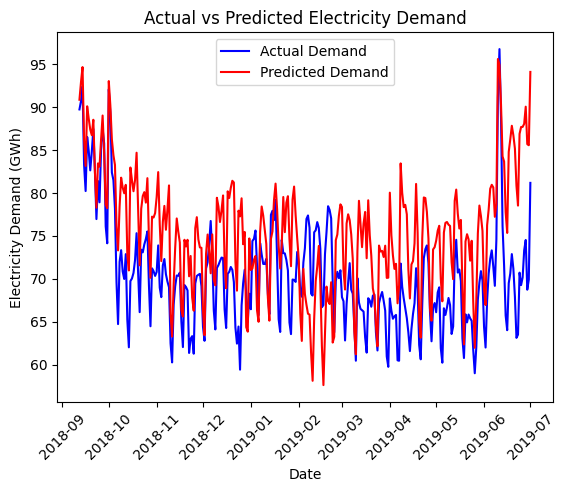

In [ ]:

# Plot actual demand data
plt.plot(test_data['ds'], test_data['y'], label='Actual Demand', color='blue')

# Plot predicted demand data
plt.plot(test_data['ds'], forecast_best['yhat'], label='Predicted Demand', color='red')

plt.xlabel('Date')
plt.ylabel('Electricity Demand (GWh)')
plt.title('Actual vs Predicted Electricity Demand')
plt.legend()
# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

<a id='xgboost'></a>
### Extreme Gradient Boosting(XGBoost) (5 points)

Develop an XGBoost model to predict the electricity demand in the next week. <br>
Requirements: please apply the hyper-parameter tuning methods you’ve learned to improve the model accuracy

#### 1) Data Preparation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# Split the dataset into features (X) and target variable (y)
X = data_refined.drop(columns=["ds", "y"])
y = data_refined["y"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2) Design model

In [ ]:
# Step 2: Design Model
# Define the XGBoost model
xgb_model = xgb.XGBRegressor()


#### 3) Train the model and save the model

In [ ]:
import joblib
# Step 3: Train the Model
# Fit the XGBoost model to the training data
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
# Save the model to a file
joblib.dump(xgb_model, 'xgb_model.pkl')

#### 4) Evaluate model

In [ ]:
# Calculate RMSE
rmse_XGB = mean_squared_error(y_test, y_pred, squared=False)

print("Root Mean Squared Error:", rmse_XGB)
# Calculate CVRMSE
cvrmse_XGB = (rmse_XGB/ np.mean(y_test)) * 100
print("CVRMSE:", cvrmse_XGB)

Root Mean Squared Error: 5.020526729525907
CVRMSE: 6.385017083774039


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### 5) Hyperparameter tuning

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.01, 0.05],
    "n_estimators": [100, 200, 300],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring="neg_mean_squared_error")

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_


In [ ]:
# Get the best parameters
best_params = grid_search.best_params_

# Initialize XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)

# Retrain the model with the best parameters
best_xgb_model.fit(X_train, y_train)

# Predict using the retrained model
y_pred = best_xgb_model.predict(X_test)

# Calculate RMSE
rmse_h_XGB = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse_h_XGB )

# Calculate CVRMSE
cvrmse_h_XGB = (rmse_h_XGB  / np.mean(y_test)) * 100
print("CVRMSE:", cvrmse_h_XGB )

Root Mean Squared Error (RMSE): 4.421122291024713
CVRMSE: 5.622705122080427


#### 6) Visualize the results
do some visualizations on our predicted output vs the actual demand data.

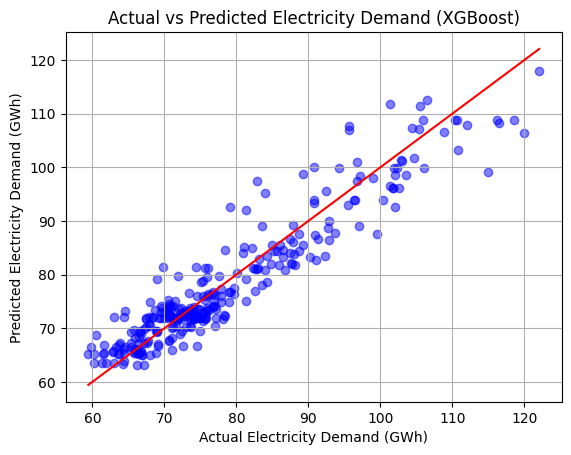

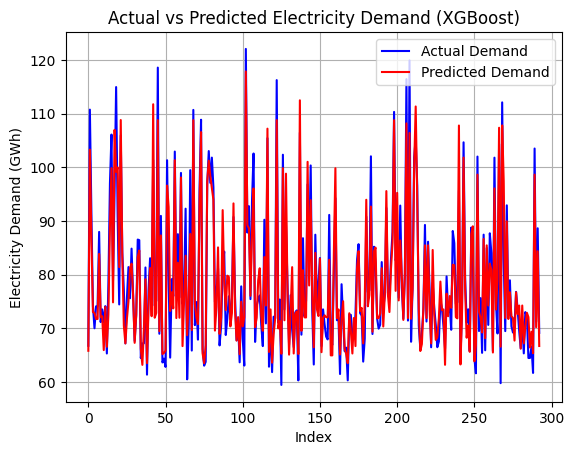

In [ ]:
# Plot actual vs predicted demand
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line representing perfect prediction
plt.xlabel('Actual Electricity Demand (GWh)')
plt.ylabel('Predicted Electricity Demand (GWh)')
plt.title('Actual vs Predicted Electricity Demand (XGBoost)')
plt.grid(True)
plt.show()

#Create a range of indices for plotting
indices = range(len(y_test))

# Plot actual demand
plt.plot(indices, y_test, label='Actual Demand', color='blue')

# Plot predicted demand
plt.plot(indices, y_pred, label='Predicted Demand', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Electricity Demand (GWh)')
plt.title('Actual vs Predicted Electricity Demand (XGBoost)')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

<a id='com'></a>
## 6. Model comparison (2 Points)

Compare the performance of these three models in terms of prediction accuracy using Root Mean Squared Error(RMSE) and Coefficient of Variation of Root Mean Squared Error(CVRMSE)

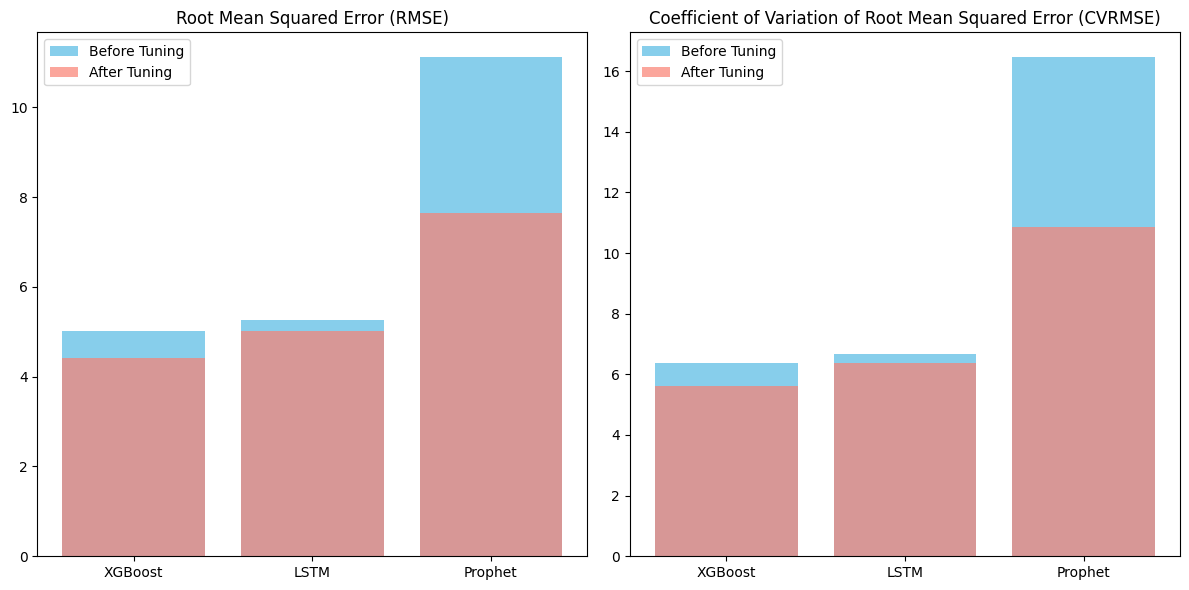

In [ ]:
import matplotlib.pyplot as plt

# Define the models and their RMSE and CVRMSE values
models = ['XGBoost', 'LSTM', 'Prophet']
rmse_values = [rmse_XGB, rmse_lstm, rmse_prophet]
cvrmse_values = [cvrmse_XGB, cvrmse_lstm, cvrmse_prophet]
rmse_h_values = [rmse_h_XGB, rmse_h_lstm, best_rmse]
cvrmse_h_values = [cvrmse_h_XGB, cvrmse_h_lstm, cvrmse_h_prophet]

# Create subplots for RMSE and CVRMSE
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot RMSE values
axes[0].bar(models, rmse_values, color='skyblue', label='Before Tuning')
axes[0].bar(models, rmse_h_values, color='salmon', label='After Tuning', alpha=0.7)
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].legend()

# Plot CVRMSE values
axes[1].bar(models, cvrmse_values, color='skyblue', label='Before Tuning')
axes[1].bar(models, cvrmse_h_values, color='salmon', label='After Tuning', alpha=0.7)
axes[1].set_title('Coefficient of Variation of Root Mean Squared Error (CVRMSE)')
axes[1].legend()

# Add labels and show plots
plt.tight_layout()
plt.show()